# **Installing necessary libraries**

In [1]:
#Downloading libraries

%pip install catboost optuna seaborn scikit-learn openpyxl nbformat ipython ipywidgets lazypredict-nightly

Note: you may need to restart the kernel to use updated packages.


In [103]:
# Importing libraries and setting necessery settings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import all the required models and methods
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import optuna
from optuna.samplers import TPESampler
import lazypredict
from lazypredict import LazyRegressor
from catboost import CatBoostRegressor, Pool, cv
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, MaxAbsScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor


%matplotlib inline
plt.style.use("seaborn-v0_8")

# **Basic EDA**

In [4]:
df = pd.read_excel("Employee Turnover Analytics Data set.xlsx")

In [5]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.00,14999.00,14999.00,14999.00,14999.00,14999.00,14999.00,14999.00
mean,0.61,0.72,3.80,201.05,3.50,0.14,0.24,0.02
std,0.25,0.17,1.23,49.94,1.46,0.35,0.43,0.14
min,0.09,0.36,2.00,96.00,2.00,0.00,0.00,0.00
25%,0.44,0.56,3.00,156.00,3.00,0.00,0.00,0.00
50%,0.64,0.72,4.00,200.00,3.00,0.00,0.00,0.00
75%,0.82,0.87,5.00,245.00,4.00,0.00,0.00,0.00
max,1.00,1.00,7.00,310.00,10.00,1.00,1.00,1.00


In [6]:
# For further simplicity the target row should be the last

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [6]:
df.drop(["left", "promotion_last_5years"], axis = 1, inplace = True)

cols = df.columns.tolist()
cols = cols[1:] + cols[:1]
df = df[cols]

In [8]:
# For further simplicity the target row should be the last

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   last_evaluation       14999 non-null  float64
 1   number_project        14999 non-null  int64  
 2   average_montly_hours  14999 non-null  int64  
 3   time_spend_company    14999 non-null  int64  
 4   Work_accident         14999 non-null  int64  
 5   sales                 14999 non-null  object 
 6   salary                14999 non-null  object 
 7   satisfaction_level    14999 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 937.6+ KB


In [88]:
target = "satisfaction_level"
df_features = [col for col in df.columns if col != target]

In [89]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
one_hot_encoded = encoder.fit_transform(df[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
df_encoded = pd.concat([df, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_columns, axis=1)

In [90]:
df_encoded_features = [col for col in df_encoded.columns if col != target]
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   last_evaluation       14999 non-null  float64
 1   number_project        14999 non-null  int64  
 2   average_montly_hours  14999 non-null  int64  
 3   time_spend_company    14999 non-null  int64  
 4   Work_accident         14999 non-null  int64  
 5   satisfaction_level    14999 non-null  float64
 6   sales_IT              14999 non-null  float64
 7   sales_RandD           14999 non-null  float64
 8   sales_accounting      14999 non-null  float64
 9   sales_hr              14999 non-null  float64
 10  sales_management      14999 non-null  float64
 11  sales_marketing       14999 non-null  float64
 12  sales_product_mng     14999 non-null  float64
 13  sales_sales           14999 non-null  float64
 14  sales_support         14999 non-null  float64
 15  sales_technical    

In [ ]:
# Getting categorical feature indecies

def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies


categorical_indicies = get_categorical_indicies(df)

# **Searching for the best model**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df[df_features], df[target],
                                                        test_size = 0.25,
                                                        random_state = 777,
                                                        shuffle = True)

reg = LazyRegressor(ignore_warnings = False)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/42 [00:00<?, ?it/s]

 98%|█████████▊| 41/42 [01:22<00:01,  1.33s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 11249, number of used features: 18
[LightGBM] [Info] Start training from score 0.611755


100%|██████████| 42/42 [01:23<00:00,  1.98s/it]


In [12]:
predictions["RMSE"].map(lambda x: '%.3f' % x)

Model
RandomForestRegressor             0.172
ExtraTreesRegressor               0.175
LGBMRegressor                     0.179
HistGradientBoostingRegressor     0.179
BaggingRegressor                  0.180
XGBRegressor                      0.182
GradientBoostingRegressor         0.183
SVR                               0.189
NuSVR                             0.189
MLPRegressor                      0.190
AdaBoostRegressor                 0.194
KNeighborsRegressor               0.197
ExtraTreeRegressor                0.232
DecisionTreeRegressor             0.235
LassoLarsIC                       0.239
LarsCV                            0.239
LassoLarsCV                       0.239
LassoCV                           0.239
ElasticNetCV                      0.239
LinearRegression                  0.239
TransformedTargetRegressor        0.239
RidgeCV                           0.239
Ridge                             0.239
Lars                              0.239
KernelRidge                       

In [13]:
model = CatBoostRegressor(
    cat_features = categorical_indicies,
)

model.fit(X_train, y_train, eval_set = [(X_test, y_test)],
            verbose = False)
preds = model.predict(X_test)
rmse = root_mean_squared_error(y_test, preds)
rmse

0.1783685810032488

In [98]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded[df_encoded_features], df_encoded[target],
                                                        test_size = 0.25,
                                                        random_state = 777,
                                                        shuffle = True)

mlp = MLPRegressor()
mlp.fit(X_train, y_train)
rmse = root_mean_squared_error(y_test, mlp.predict(X_test))
rmse

0.20352978180372047

# **RandomForest**

In [105]:

def objective(trial):
    # split data in training and test data
    X_train, X_test, y_train, y_test = train_test_split(df_encoded[df_encoded_features], df_encoded[target],
                                                        test_size=0.25,
                                                        random_state=777)

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None
    

    # Tune estimator algorithm
    param = { 
        "n_estimators": trial.suggest_int('n_estimators', 10, 500),
        "criterion": trial.suggest_categorical('criterion', 
                                               ["squared_error", "absolute_error", 'friedman_mse', 'poisson']),
        "max_depth": trial.suggest_int('max_depth', 4, 20),
        "min_samples_split": trial.suggest_int('min_samples_split', 2, 200),
        "min_samples_leaf": trial.suggest_int('min_samples_leaf', 2, 200),
        "min_weight_fraction_leaf": trial.suggest_float('min_weight_fraction_leaf', 0, 0.5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        "max_leaf_nodes": trial.suggest_int('max_leaf_nodes', 2, 200),
        "min_impurity_decrease": trial.suggest_float('min_impurity_decrease', 0, 1)
   } 
     
    rfr = RandomForestRegressor(
        random_state = 777,
        **param)

    # Make a pipeline
    pipeline = make_pipeline(scaler, rfr)
    pipeline.fit(X_train, y_train)


    # Predict and estimate results
    preds = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)

    return rmse


sampler = TPESampler(multivariate = True, group = True, seed = 777)
study = optuna.create_study(study_name = "RFR", sampler = sampler)
study.optimize(objective, n_trials = 150)
trial = study.best_trial

print("Number of finished trials: ", len(study.trials))
print("Best trial:", trial.number)
print("  Value: ", trial.value)
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-05-19 01:39:08,712] A new study created in memory with name: RFR


[I 2024-05-19 01:39:13,002] Trial 0 finished with value: 0.17205129966087637 and parameters: {'scalers': None}. Best is trial 0 with value: 0.17205129966087637.
[I 2024-05-19 01:39:17,288] Trial 1 finished with value: 0.17191107760190635 and parameters: {'scalers': 'minmax'}. Best is trial 1 with value: 0.17191107760190635.
[I 2024-05-19 01:39:21,558] Trial 2 finished with value: 0.17205129966087637 and parameters: {'scalers': None}. Best is trial 1 with value: 0.17191107760190635.
[I 2024-05-19 01:39:25,719] Trial 3 finished with value: 0.17193844151614635 and parameters: {'scalers': 'standard'}. Best is trial 1 with value: 0.17191107760190635.
[I 2024-05-19 01:39:29,803] Trial 4 finished with value: 0.17205129966087637 and parameters: {'scalers': None}. Best is trial 1 with value: 0.17191107760190635.
[I 2024-05-19 01:39:33,800] Trial 5 finished with value: 0.17191107760190635 and parameters: {'scalers': 'minmax'}. Best is trial 1 with value: 0.17191107760190635.
[I 2024-05-19 01:39:

KeyboardInterrupt: 

In [95]:
# History of optimization

optuna.visualization.plot_optimization_history(study)

In [96]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study)

In [97]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study)

In [ ]:
# define optimal hyperparameters
params = study.best_trial.params
del params['scalers']
scaler_rfr = RobustScaler()
rfr = RandomForestRegressor(**params)

# create and fit pipeline
pipeline_rfr = make_pipeline(scaler_rfr, rfr)

In [ ]:
scores_rfr = cross_val_score(pipeline_rfr, df_encoded[df_encoded_features], df_encoded[target],  scoring = 'neg_root_mean_squared_error') * (-1)
score_mean_rfr = scores_rfr.mean()
print(scores_rfr, "Средняя оценка:", score_mean_rfr)

[0.16065181 0.21176474 0.20914574 0.15613418 0.00597269] Средняя оценка: 0.1487338319854023


# **KNN**

In [40]:

def objective(trial):
    # split data in training and test data
    X_train, X_test, y_train, y_test = train_test_split(df_encoded[df_encoded_features], df_encoded[target],
                                                        test_size=0.25,
                                                        random_state=777)

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    # Tune estimator algorithm
    n_neighbors = trial.suggest_int("n_neighbors", 1, 500)
    weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
    metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, metric=metric)

    # Make a pipeline
    pipeline = make_pipeline(scaler, knn)
    pipeline.fit(X_train, y_train)


    # Predict and estimate results
    preds = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)

    return rmse


sampler = TPESampler(multivariate = True, group = True, seed = 777)
study = optuna.create_study(study_name = "KNN", sampler = sampler)
study.optimize(objective, n_trials = 150)
trial = study.best_trial

print("Number of finished trials: ", len(study.trials))
print("Best trial:", trial.number)
print("  Value: ", trial.value)
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

c:\Users\Aleks\Desktop\Jupyter\Cat_Model\.venv\Lib\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning:

``multivariate`` option is an experimental feature. The interface can change in the future.

c:\Users\Aleks\Desktop\Jupyter\Cat_Model\.venv\Lib\site-packages\optuna\samplers\_tpe\sampler.py:330: ExperimentalWarning:

``group`` option is an experimental feature. The interface can change in the future.

[I 2024-05-17 19:52:17,910] A new study created in memory with name: KNN
[I 2024-05-17 19:52:18,342] Trial 0 finished with value: 0.17735936362636037 and parameters: {'scalers': 'standard', 'n_neighbors': 230, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.17735936362636037.
[I 2024-05-17 19:52:18,777] Trial 1 finished with value: 0.17971799732629964 and parameters: {'scalers': 'minmax', 'n_neighbors': 295, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.17735936362636037.
[I 2024-05-17 19:52:19,008] Trial 2 

Number of finished trials:  200
Best trial: 59
  Value:  0.16916831561261356
  Params: 
    scalers: robust
    n_neighbors: 153
    weights: distance
    metric: manhattan


In [41]:
# History of optimization

optuna.visualization.plot_optimization_history(study)

In [42]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study)

In [43]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study)

In [20]:
# define optimal hyperparameters
scaler_knn = RobustScaler()
knn = KNeighborsRegressor(n_neighbors = 153, weights = 'distance', metric = 'manhattan')

# create and fit pipeline
pipeline_knn = make_pipeline(scaler_knn, knn)

In [60]:
scores_knn = cross_val_score(pipeline_knn, df_encoded[df_encoded_features], df_encoded[target],  scoring = 'neg_root_mean_squared_error') * (-1)
score_mean_knn = scores_knn.mean()
print(scores_knn, "Средняя оценка:", score_mean_knn)

[0.16065181 0.21176474 0.20914574 0.15613418 0.00597269] Средняя оценка: 0.1487338319854023


# **GBM - CatBoost**

In [52]:
cat_data = df
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   last_evaluation       14999 non-null  float64
 1   number_project        14999 non-null  int64  
 2   average_montly_hours  14999 non-null  int64  
 3   time_spend_company    14999 non-null  int64  
 4   Work_accident         14999 non-null  int64  
 5   sales                 14999 non-null  object 
 6   salary                14999 non-null  object 
 7   satisfaction_level    14999 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 937.6+ KB


In [43]:
features = [col for col in cat_data.columns if col != target]
number_columns = cat_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [82]:
data = cat_data[features]
number_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = RobustScaler()
data_scaler = scaler.fit_transform(data[number_columns])
data_scaler = pd.DataFrame(data_scaler, columns=scaler.get_feature_names_out(number_columns))
df_scaled = pd.concat([data, data_scaler], axis=1)
df_scaled = df_scaled.loc[:, 'sales':]
df_scaled

,sales,salary,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident
0,sales,low,-0.61,-1.00,-0.48,0.00,0.00
1,sales,medium,0.45,0.50,0.70,3.00,0.00
2,sales,medium,0.52,1.50,0.81,1.00,0.00
3,sales,low,0.48,0.50,0.26,2.00,0.00
4,sales,low,-0.65,-1.00,-0.46,0.00,0.00
...,...,...,...,...,...,...,...
14994,support,low,-0.48,-1.00,-0.55,0.00,0.00
14995,support,low,-0.77,-1.00,-0.45,0.00,0.00
14996,support,low,-0.61,-1.00,-0.64,0.00,0.00
14997,support,low,0.77,1.00,0.90,1.00,0.00


In [87]:
# Find best hyperparameters using Optuna library

def objective(trial, data = cat_data[features], target = cat_data[target]):


    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    data_scaler = scaler.fit_transform(data[number_columns])
    data_scaler = pd.DataFrame(data_scaler, columns=scaler.get_feature_names_out(number_columns))
    df_scaled = pd.concat([data, data_scaler], axis=1)
    data = df_scaled.loc[:, 'sales':]
    
    train_x, test_x, train_y, test_y = train_test_split(data, target,
                                                        test_size=0.25,
                                                        random_state=777)
    param = {
        "n_estimators": trial.suggest_int('n_estimators', 200, 1000),
        "learning_rate": trial.suggest_float('learning_rate', 0, 0.3),
        "depth": trial.suggest_int('depth', 4, 16),
        "l2_leaf_reg": trial.suggest_float('l2_leaf_reg', 0, 10),
        "border_count": trial.suggest_int('border_count', 100, 500),
        "random_strength": trial.suggest_float('random_strength', 0, 10),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'grow_policy': trial.suggest_categorical('grow_policy',
            ["Depthwise", "SymmetricTree", 'Lossguide'])
    }

    if param["bootstrap_type"] == "Bayesian":
      param["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 10)

    else:
      param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    if param["grow_policy"] == "Depthwise":
      param["min_data_in_leaf"] = trial.suggest_int('min_data_in_leaf', 1, 100)
    elif param["grow_policy"] == 'Lossguide':
       param["max_leaves"] = trial.suggest_int('max_leaves', 1, 70)

    model = CatBoostRegressor(
        loss_function = 'RMSE',
        eval_metric = "RMSE",
        random_state = 777,
        use_best_model = True,
        od_type = "Iter",
        od_wait = 25,
        cat_features = [0, 1],
        **param
    )

    model.fit(train_x, train_y, eval_set = [(test_x, test_y)],
              verbose = False)
    preds = model.predict(test_x)
    rmse = root_mean_squared_error(test_y, preds)

    return rmse



sampler = TPESampler(multivariate = True, group = True, seed = 777)
study = optuna.create_study(study_name = "catboost", sampler = sampler)
study.optimize(objective, n_trials = 150)
trial = study.best_trial

print("Number of finished trials: ", len(study.trials))
print("Best trial:", trial.number)
print("  Value: ", trial.value)
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-05-19 00:58:59,741] A new study created in memory with name: catboost


[I 2024-05-19 01:00:15,369] Trial 0 finished with value: 0.18081245304123997 and parameters: {'scalers': 'standard', 'n_estimators': 568, 'learning_rate': 0.2505760153312885, 'depth': 16, 'l2_leaf_reg': 7.269889843190701, 'border_count': 408, 'random_strength': 2.692050664721932, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Lossguide', 'bagging_temperature': 6.26473206229759, 'max_leaves': 48}. Best is trial 0 with value: 0.18081245304123997.
[I 2024-05-19 01:00:32,684] Trial 1 finished with value: 0.17945564740990094 and parameters: {'scalers': 'minmax', 'n_estimators': 378, 'learning_rate': 0.0559327801070181, 'depth': 9, 'l2_leaf_reg': 1.9316240563682419, 'border_count': 344, 'random_strength': 8.82808447266879, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Depthwise', 'bagging_temperature': 5.184958191221346, 'min_data_in_leaf': 61}. Best is trial 1 with value: 0.17945564740990094.
[I 2024-05-19 01:00:36,085] Trial 2 finished with value: 0.1809173951555256 and parameters: {'scaler

KeyboardInterrupt: 

In [ ]:
# History of optimization

optuna.visualization.plot_optimization_history(study)

In [61]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study)

In [ ]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study)

In [62]:
params = study.best_trial.params
params['loss_function'] = 'RMSE'
params['od_type'] = 'Iter'
params['od_wait'] = 25
params

{'n_estimators': 765,
 'learning_rate': 0.12130510601833022,
 'depth': 16,
 'l2_leaf_reg': 6.066574058552226,
 'border_count': 431,
 'random_strength': 0.8578928621416503,
 'bootstrap_type': 'Bayesian',
 'grow_policy': 'Depthwise',
 'bagging_temperature': 5.440658034475831,
 'min_data_in_leaf': 3,
 'loss_function': 'RMSE',
 'od_type': 'Iter',
 'od_wait': 25}

In [63]:
# Creating CV

cat_train_data = Pool(
    data = cat_data[features],
    label = cat_data[target],
    cat_features = categorical_indicies,
)

cv_data = cv(
    pool = cat_train_data,
    params = params,
    fold_count = 5,
    shuffle = True,
    partition_random_seed = 777,
    plot = True,
    stratified = True, 
    verbose = False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1736578541
bestIteration = 223

Training on fold [1/5]

bestTest = 0.1753402097
bestIteration = 334

Training on fold [2/5]

bestTest = 0.1745438723
bestIteration = 225

Training on fold [3/5]


KeyboardInterrupt: 

In [ ]:
# Creating the model with best hyperparameters

cat_model = CatBoostRegressor(loss_function = 'RMSE',
                        random_state = 777,
                        od_type = "Iter",
                        od_wait = 25,
                        **study.best_trial.params)

cat_model.fit(cat_train_data, verbose = False)

Text(0.5, 1.0, 'Feature Importance')

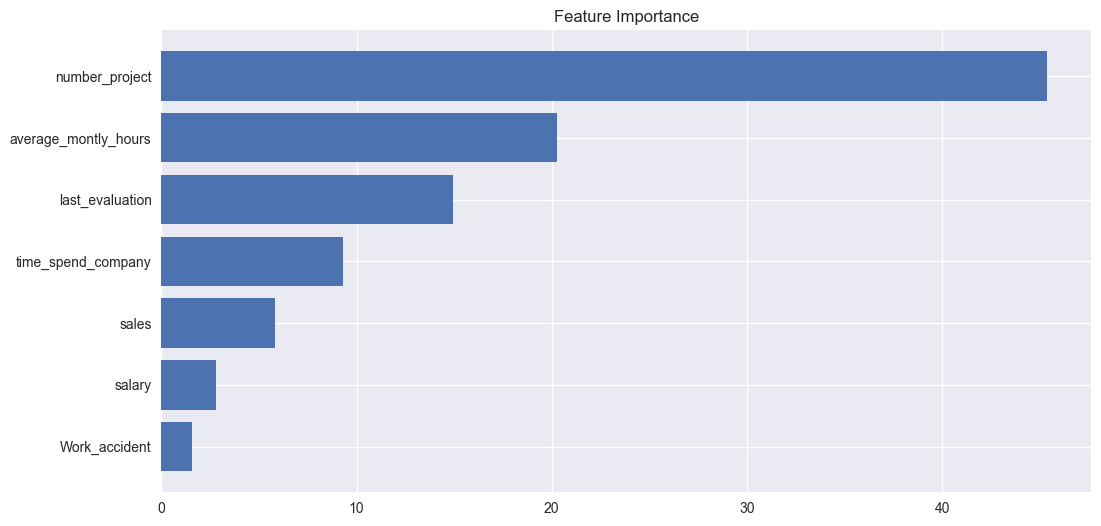

In [ ]:
# Plotting feature importance

feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(np.array(features)[sorted_idx], feature_importance[sorted_idx])
plt.title('Feature Importance')